In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [6]:
file_path = 'creditcard_2013.csv'
data = pd.read_csv(file_path)

X = data.drop('Class', axis=1)
################################
tot_seconds = X['Time']
X['sin_tot_seconds'] = np.sin(2 * np.pi * tot_seconds / (24 * 60 * 60))
X['cos_tot_seconds'] = np.cos(2 * np.pi * tot_seconds / (24 * 60 * 60))
X = X.drop('Time', axis=1)
amount_pt = PowerTransformer(method='box-cox')
X['Amount'] = amount_pt.fit_transform(X[['Amount']] + 1e-9)
################################

y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=6, eval_metric='AUC', verbose=100)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

train_start_time = time.time()
model.fit(train_pool)
train_end_time = time.time()
training_duration = train_end_time - train_start_time
print(f'Total Training Time: {training_duration:.2f} seconds')

0:	total: 139ms	remaining: 2m 19s
100:	total: 4.25s	remaining: 37.8s
200:	total: 8.64s	remaining: 34.3s
300:	total: 13.3s	remaining: 31s
400:	total: 17.3s	remaining: 25.8s
500:	total: 21.3s	remaining: 21.2s
600:	total: 23.5s	remaining: 15.6s
700:	total: 24.9s	remaining: 10.6s
800:	total: 26.4s	remaining: 6.55s
900:	total: 27.8s	remaining: 3.05s
999:	total: 29.2s	remaining: 0us
Total Training Time: 29.77 seconds


Total Evaluation Time: 0.04 seconds
Test Accuracy: 0.9996
Precision: 0.9398
Recall (TPR): 0.7959
TNR: 0.9999
F1 Score: 0.8619
ROC AUC: 0.9754


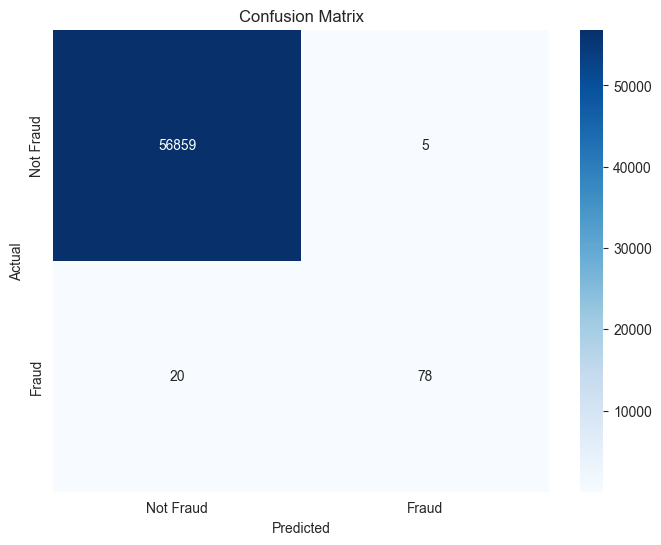

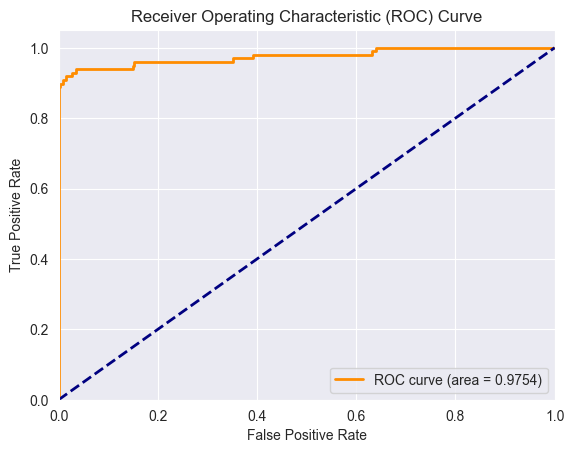

CatBoost Model


In [8]:
eval_start_time = time.time()
y_pred = model.predict(test_pool)
y_pred_prob = model.predict_proba(test_pool)[:, 1]
eval_end_time = time.time()
evaluation_duration = eval_end_time - eval_start_time
print(f'Total Evaluation Time: {evaluation_duration:.2f} seconds')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
tnr = tn / (tn + fp)

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (TPR): {recall:.4f}')
print(f'TNR: {tnr:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("CatBoost Model")